In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import h5py

from matplotlib.colors import LogNorm
from scipy import stats
from dataload import load_json_config,process_data,load_data

In [2]:
import sys
sys.path.append('./')
from pytorch3dunet.unet3d.model import UNet3D,ResidualUNet3D

### Load trained model

In [ ]:
device='cpu'
ckp='checkpoint_model_29999.pth'
size=64
pad=16
config = load_json_config(custom_path='config.json')


In [4]:

model_b=ResidualUNet3D(in_channels=config["input_channels"],out_channels=config["output_channels_b"],\
                f_maps=config["nchan"],num_levels=config["deep"],\
                conv_upscale=2,\
                upsample='deconv',\
                layer_order='cbr',\
                final_sigmoid=False, is_segmentation=False,dropout_prob=0.0).to(device)

model_z=ResidualUNet3D(in_channels=config["input_channels"],out_channels=config["output_channels_z"],\
                f_maps=config["nchan"],num_levels=config["deep"],\
                conv_upscale=2,\
                upsample='deconv',\
                layer_order='cbr',\
                final_sigmoid=False, is_segmentation=False,dropout_prob=0.0).to(device)


In [5]:
checkpoint = torch.load(ckp, map_location='cpu')

model_state_dict = checkpoint['model_b']
if isinstance(model_b, torch.nn.DataParallel) or isinstance(model_b, torch.nn.parallel.DistributedDataParallel):
        # If the model is wrapped, we need to load the state_dict into model_b.module
    model_b.module.load_state_dict(model_state_dict)
else:
    # If the model is not wrapped, load the state_dict directly
    model_b.load_state_dict(model_state_dict)

model_state_dict = checkpoint['model_z']
if isinstance(model_z, torch.nn.DataParallel) or isinstance(model_z, torch.nn.parallel.DistributedDataParallel):
        # If the model is wrapped, we need to load the state_dict into model_z.module
    model_z.module.load_state_dict(model_state_dict)
else:
    # If the model is not wrapped, load the state_dict directly
    model_z.load_state_dict(model_state_dict)



### Load data
##### try to load the data into one batch, and get a smooth prediction without using split and stitch with a pad zone.

In [6]:
bx,bx1,by,by1,bz,Zini,_,bscale=load_data(filename=config['filename'],hsize=config['hsize'],istart=0)

dataset=torch.zeros((1,6,size*4,size*4,32),dtype=torch.float32)

dataset[0,0]=torch.tensor(bx[2*size:6*size,2*size:6*size],dtype=torch.float32)
dataset[0,1]=torch.tensor(by[2*size:6*size,2*size:6*size],dtype=torch.float32)
dataset[0,2]=torch.tensor(bz[2*size:6*size,2*size:6*size],dtype=torch.float32)
dataset[0,3]=torch.tensor(Zini[2*size:6*size,2*size:6*size],dtype=torch.float32)
dataset[0,4]=torch.tensor(bx1[2*size:6*size,2*size:6*size],dtype=torch.float32)
dataset[0,5]=torch.tensor(by1[2*size:6*size,2*size:6*size],dtype=torch.float32)


In [7]:
del bx, by, bz, Zini, bx1, by1

### Load true $\vec{B}$ and Z

In [8]:
with h5py.File(config['filename'],'r') as f:
    Ztrue = f['tz3d'][:]
    Bxtrue = f['bx'][:]
    Bytrue = f['by'][:]
    Bztrue = f['bz'][:]
    bscale=np.nanmax(np.sqrt(f['bx'][:]**2 + f['by'][:]**2 + f['bz'][:]**2))

Ztrue=Ztrue[2*size:6*size,2*size:6*size]
Bxtrue=Bxtrue[2*size:6*size,2*size:6*size]/bscale
Bytrue=Bytrue[2*size:6*size,2*size:6*size]/bscale
Bztrue=Bztrue[2*size:6*size,2*size:6*size]/bscale

### Apply model to data

In [9]:
pred_b=np.zeros((dataset.shape[0],3,dataset.shape[2],dataset.shape[3],dataset.shape[4]))
pred_z=np.zeros((dataset.shape[0],1,dataset.shape[2],dataset.shape[3],dataset.shape[4]))

In [10]:
with torch.no_grad():
    for ix in tqdm(range(dataset.shape[0])):
        pred_b[ix]=torch.tanh(model_b(dataset[ix].unsqueeze(0))).detach().numpy()

100%|██████████| 1/1 [00:16<00:00, 16.51s/it]


In [11]:
with torch.no_grad():
    for ix in tqdm(range(dataset.shape[0])):
        pred_z[ix]=torch.tanh(model_z(dataset[ix].unsqueeze(0))).detach().numpy()

100%|██████████| 1/1 [00:16<00:00, 16.41s/it]


### Map the splited data back the original data shape.

In [12]:
Bxp=pred_b[0,0]
Byp=pred_b[0,1]
Bzp=pred_b[0,2]
Zp=pred_z[0,0]

In [13]:
del pred_b
del pred_z

### Visualization of $\vec{B}$ and $Z$, prediction vs. Truth on $\tau=1.6$ for each batch.
#### Bottom is prediction, top is true value.

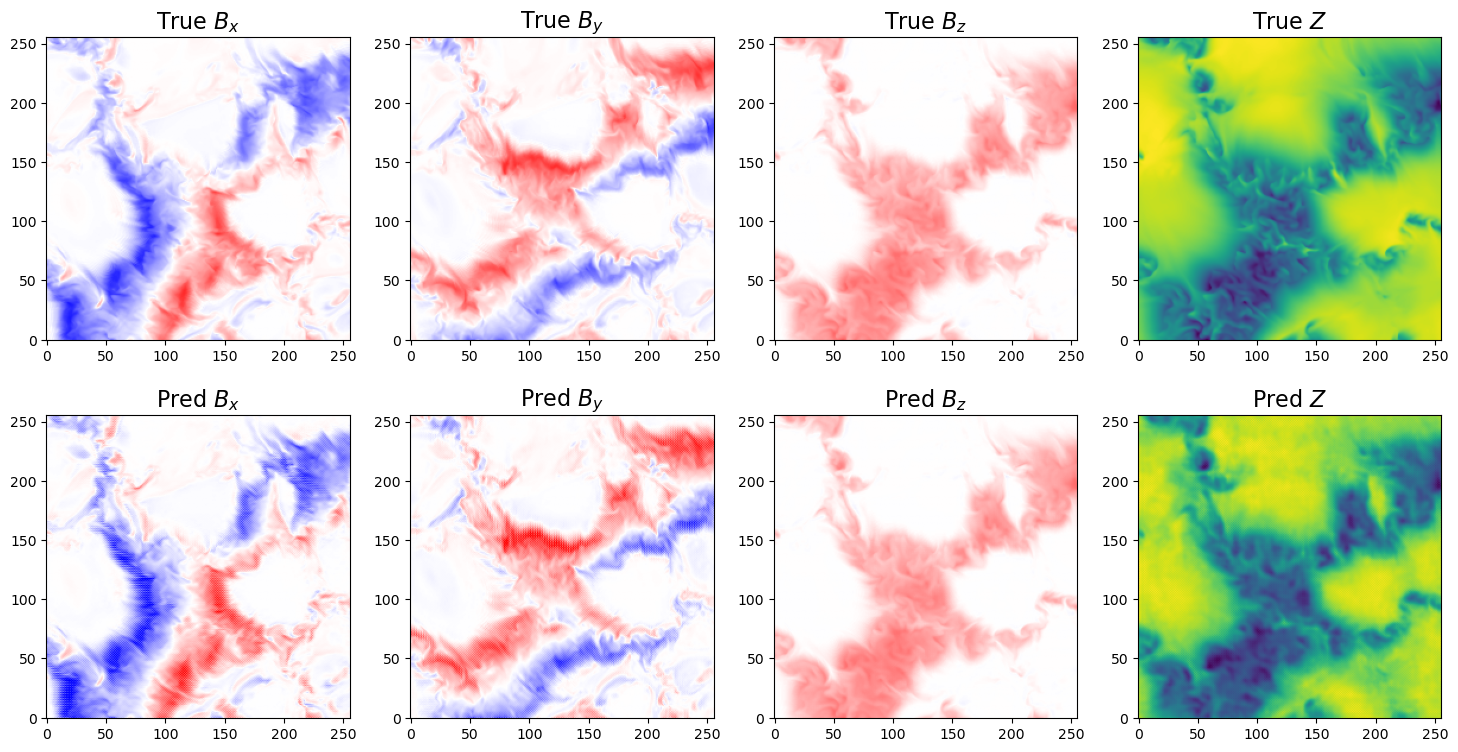

In [14]:
fig,axs=plt.subplots(2,4,figsize=(18,9))
itau=16

axs[0,0].imshow(Bxtrue[...,itau].T,origin='lower',vmin=-0.3,vmax=0.3,cmap='bwr')
axs[1,0].imshow(Bxp[...,itau].T,origin='lower',vmin=-0.3,vmax=0.3,cmap='bwr')


axs[0,1].imshow(Bytrue[...,itau].T,origin='lower',vmin=-0.3,vmax=0.3,cmap='bwr')
axs[1,1].imshow(Byp[...,itau].T,origin='lower',vmin=-0.3,vmax=0.3,cmap='bwr')


axs[0,2].imshow(Bztrue[...,itau].T,origin='lower',vmin=-1,vmax=1,cmap='bwr')
axs[1,2].imshow(Bzp[...,itau].T,origin='lower',vmin=-1,vmax=1,cmap='bwr')

axs[0,3].imshow(Ztrue[...,itau].T,origin='lower')
axs[1,3].imshow(Zp[...,itau].T,origin='lower')

titlename=[r'True $B_x$',r'True $B_y$',r'True $B_z$',r'True $Z$',\
           r'Pred $B_x$',r'Pred $B_y$',r'Pred $B_z$',r'Pred $Z$']

axs=axs.flatten()
for ix in range(len(axs)):
    axs[ix].set_title(titlename[ix],fontsize=16)



### Check the ambiguity result

In [15]:
tmp=Bxtrue+1j*Bytrue
phi_true=np.angle(tmp)

tmp= Bxp+1j*Byp
phi_pred=np.angle(tmp)

In [16]:
binsize=1024
phisize=2048
d_phi=np.mod(phi_true-phi_pred,2*np.pi)
babs=np.sqrt(Bxtrue**2+Bytrue**2)
minvalue=np.log10(babs.min())
maxvalue=np.log10(babs.max())
val=np.logspace(minvalue,maxvalue,binsize)
d_phi=np.mod(phi_true-phi_pred,2*np.pi)
bins=(val,np.linspace(0,2*np.pi,phisize))
depart,yedges,xedges=np.histogram2d(babs[:,:,:].flatten(),d_phi[:,:,:].flatten(),bins=bins,density=False)
accurate=1-np.sum(depart[:,phisize//4:3*phisize//4],axis=1)/np.sum(depart,axis=1)

/var/folders/rr/2n3c73qx6r141zscx2v__r9w0000gn/T/ipykernel_36137/117300874.py:11: RuntimeWarning: invalid value encountered in divide
  accurate=1-np.sum(depart[:,phisize//4:3*phisize//4],axis=1)/np.sum(depart,axis=1)


Text(0.5, 0, '|Bt|')

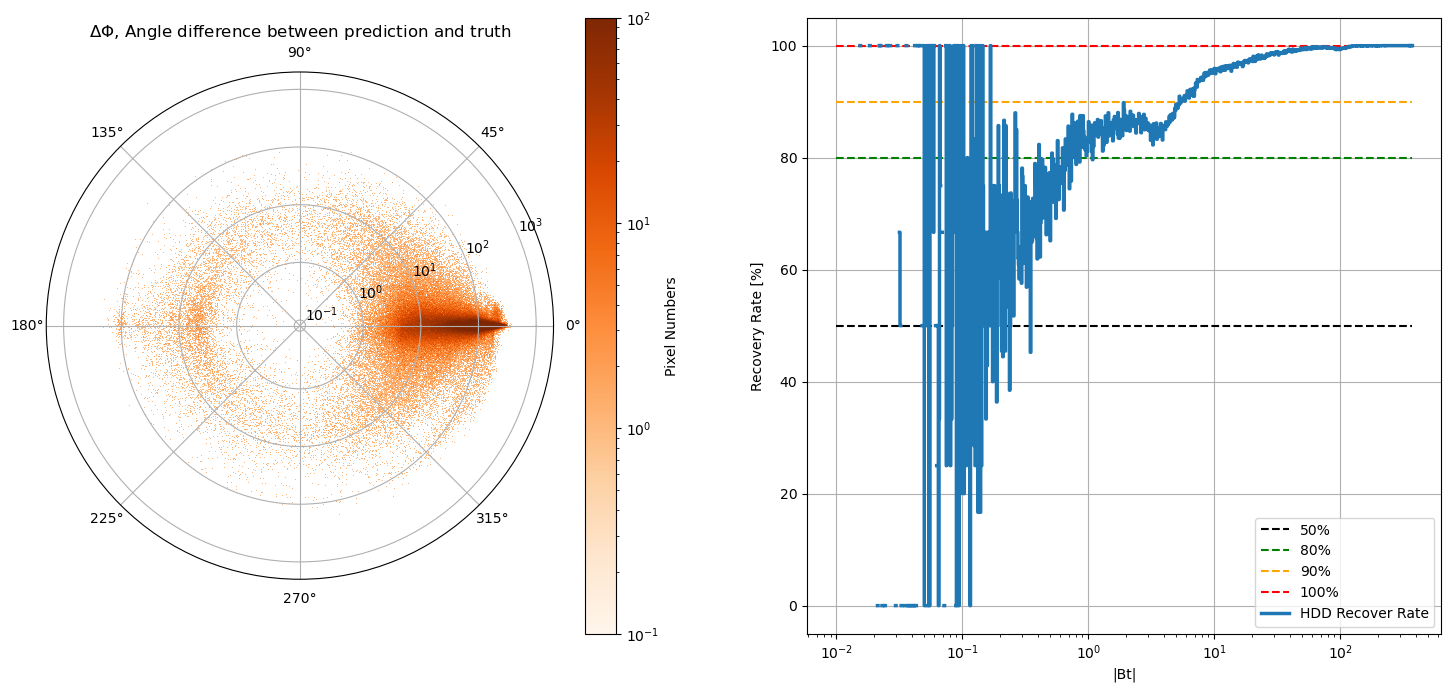

In [17]:
plt.figure(figsize=(18, 8))
ax = plt.subplot(121, polar=True)  # Create a polar subplot
c = ax.pcolormesh(xedges, yedges*bscale, depart, norm=LogNorm(vmax=1e2,vmin=1e-1),cmap='Oranges')  # Note the transpose of data to align axes
plt.colorbar(c, ax=ax,label='Pixel Numbers')  # Add a colorbar to show the data scale
ax.set_title(r'$\Delta\Phi$, Angle difference between prediction and truth')
plt.yscale('log')
plt.ylim([8e-2,2e3])

ax1 = plt.subplot(122)  # Create a polar subplot
xx=bscale*yedges
midpoints = bscale*(yedges[:-1] + yedges[1:]) / 2
ax1.plot([midpoints.min(),midpoints.max()],[50,50],'k--',label='50%')
ax1.plot([midpoints.min(),midpoints.max()],[80,80],linestyle='--',color='green',label='80%')
ax1.plot([midpoints.min(),midpoints.max()],[90,90],linestyle='--',color='orange',label='90%')
ax1.plot([midpoints.min(),midpoints.max()],[100,100],linestyle='--',color='red',label='100%')
ax1.set_ylabel('Recovery Rate [%]')
ax1.step(midpoints, accurate*100, where='mid', linewidth=2.5,label='HDD Recover Rate')
ax1.grid()

ax1.legend()
ax1.set_xscale('log')
ax1.set_xlabel('|Bt|')

### Check prediction of geometric height

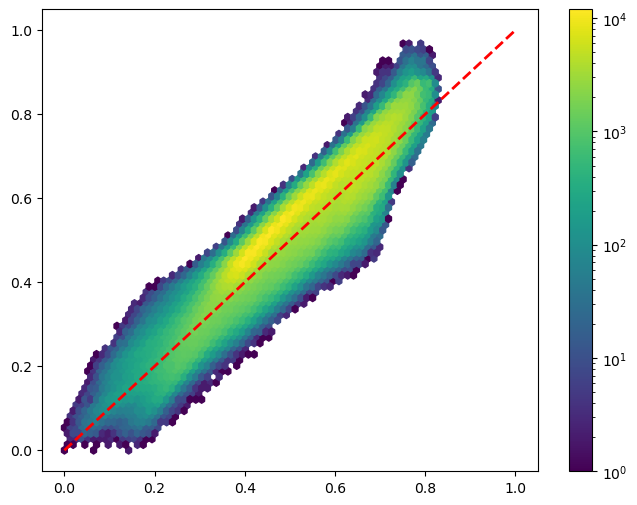

In [18]:
fig=plt.figure(figsize=(8, 6))
ilayer=1

plt.hexbin(Zp[...,:].flatten()-Zp.min(),Ztrue[...,:].flatten()-Ztrue.min(),bins='log',gridsize=64,alpha=1)
plt.plot([0,1],[0,1],'r--',linewidth=2,label='x=y line')

plt.colorbar()